# Audio Modulation and Demodulation
## AM Performance in Noise

### Step 1: Build the Envelope Detectoor
Demo Infor:

Message signal: $x(t) = \sin(2\pi f_{m1} t) + \sin(2\pi f_{m2} t)$ where $f_{m1} = 50~\text{Hz}$ and $f_{m2} = 120~\text{Hz}$.

Sampling Rate: $f_s = 1\times 10^{4}~\text{Hz}$.

Duration: $0.1~\text{s}$.

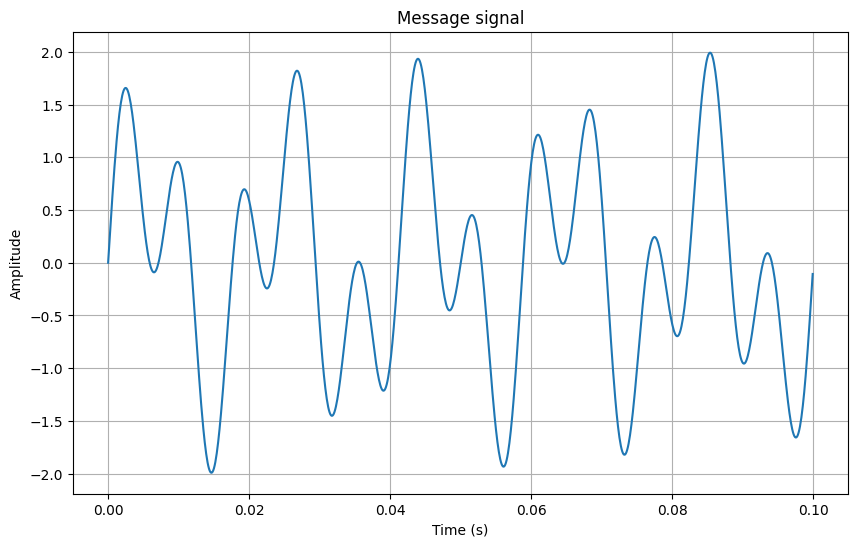

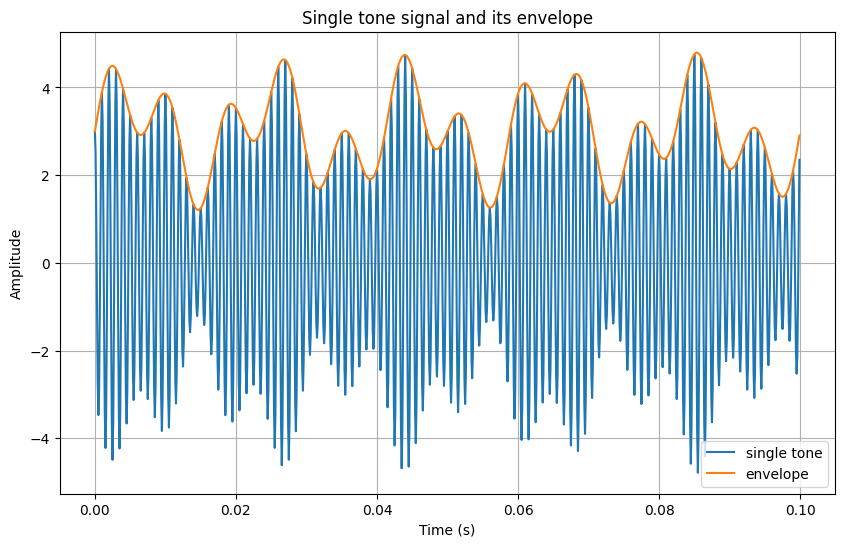

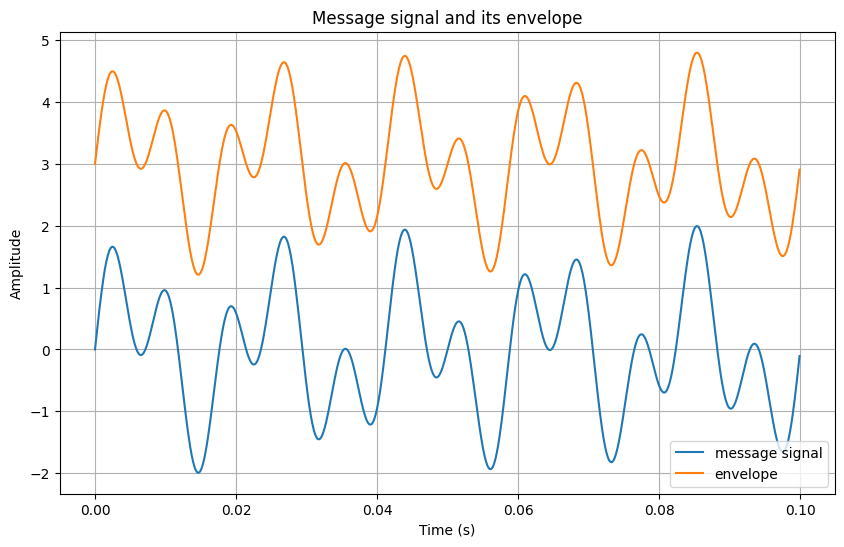

In [7]:
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (10,6)
# The envelope detector implemented using the Hilbert transform
# See: https://blog.csdn.net/m0_37262671/article/details/125303404
def get_envelope(x, n=None):
    analytic_signal = hilbert(x, N=n)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

# generate a signal for demo
fs = 10000
fc = 1000
fm1 = 50
fm2 = 120
Ac = 3
u=0.3 # modulation index
t = np.arange(0, 0.1, 1/fs)
message_signal = np.sin(2*np.pi*fm1*t) + np.sin(2*np.pi*fm2*t)
# multiply with a carrier signal to get AM modulated signal
am_signal = Ac * (1 + u*message_signal) * np.cos(2*np.pi*fc*t)

# plot the message signal
plt.figure()
plt.plot(t, message_signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Message signal')
plt.grid(True)
plt.show()


# plot the single_tone and the envelope signal in the same plot
plt.figure()
plt.plot(t, am_signal, label='single tone')
plt.plot(t, get_envelope(am_signal), label='envelope')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Single tone signal and its envelope')
plt.grid(True)
plt.legend()
plt.show()

# compare the original message signal and the envelope signal
plt.figure()
plt.plot(t, message_signal, label='message signal')
plt.plot(t, get_envelope(am_signal), label='envelope')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Message signal and its envelope')
plt.grid(True)
plt.legend()
plt.show()


### Step 2: Generate the required AM system

Normalization factor:  16412
Carrier frequency:  4800.0
Bandwidth of the audio signal:  24000.0


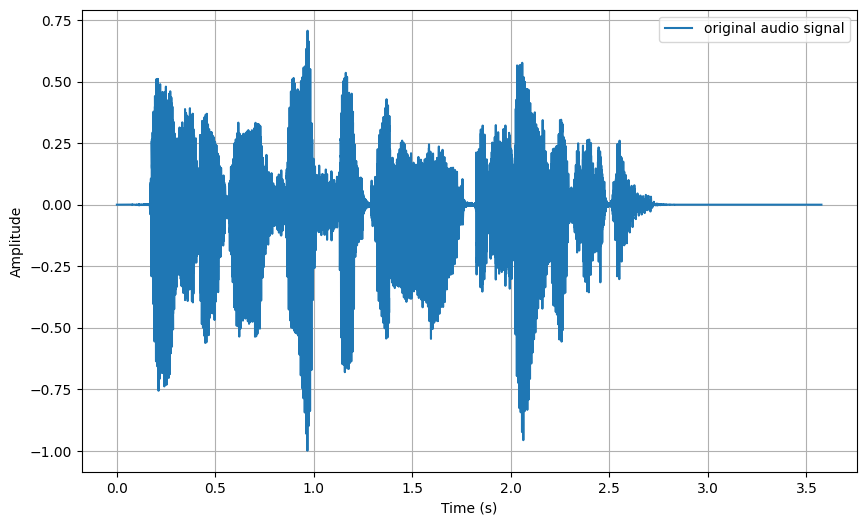

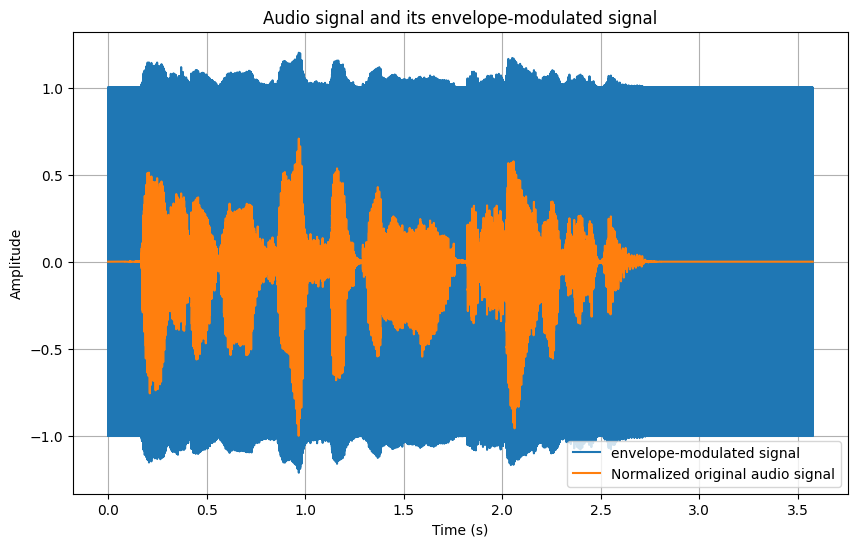

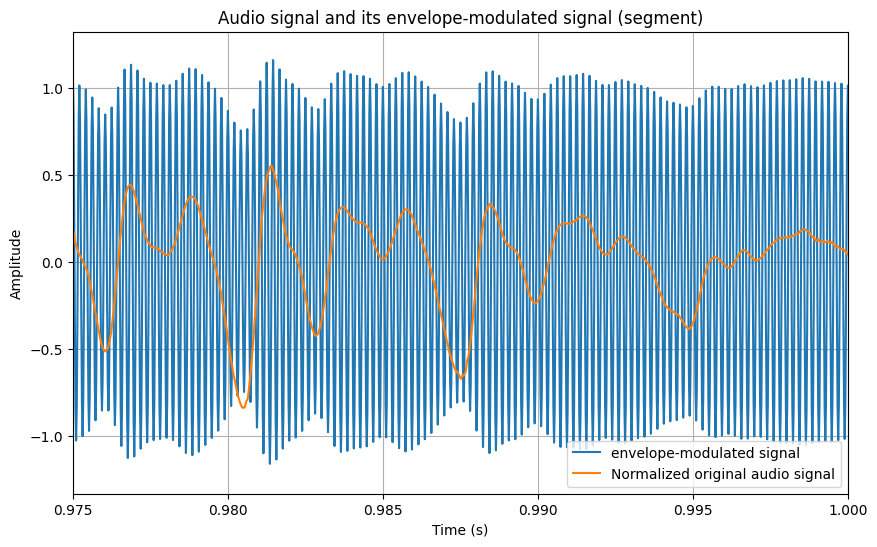

In [8]:
# Generate the AM signal using specified wav file
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np

# read the wav file
fs, orig_data = wavfile.read('audio.wav')

# normalize the data
data = orig_data
nf = np.max(np.abs(data))   # normalization factor nf
data = data/nf

print('Normalization factor: ', nf)

# set the carrier frequency
fc = fs/10
print('Carrier frequency: ', fc)

# generate the time vector
t = np.arange(0, len(data)/fs, 1/fs)
u = 0.3
ka = u / np.max(np.abs(data))

# set carrier amplitude Ac
Ac = 1  # carrier amplitude
bw = fs/2  # bandwidth of the audio signal
print('Bandwidth of the audio signal: ', bw)

# generate the envelope-modulated signal based on the audio signal
am_signal = Ac*(1 + ka*data) * np.cos(2*np.pi*fc*t)

# plot the original audio signal
plt.figure()
plt.plot(t, data, label='original audio signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

# plot the original audio signal and the envelope-modulated signal
plt.figure()
plt.plot(t, am_signal, label='envelope-modulated signal')
plt.plot(t, data, label='Normalized original audio signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio signal and its envelope-modulated signal')
plt.grid(True)
plt.legend()
plt.show()

# plot the original audio signal and the envelope-modulated signal
plt.figure()
plt.plot(t, am_signal, label='envelope-modulated signal')
plt.plot(t, data, label='Normalized original audio signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0.975,1)
plt.title('Audio signal and its envelope-modulated signal (segment)')
plt.grid(True)
plt.legend()
plt.show()

# write the envelope-modulated signal to a wav file, do not use float
wavfile.write('audio_modulated.wav', fs, am_signal.astype('int16'))


By now the envelope-modulated AM wave has been generated.

Next, we are going to implement the receiver.

### Step 3: Add some noise

Pre-detection SNR: 60.00 dB
Theoretical pre-detection SNR: 44.94 dB


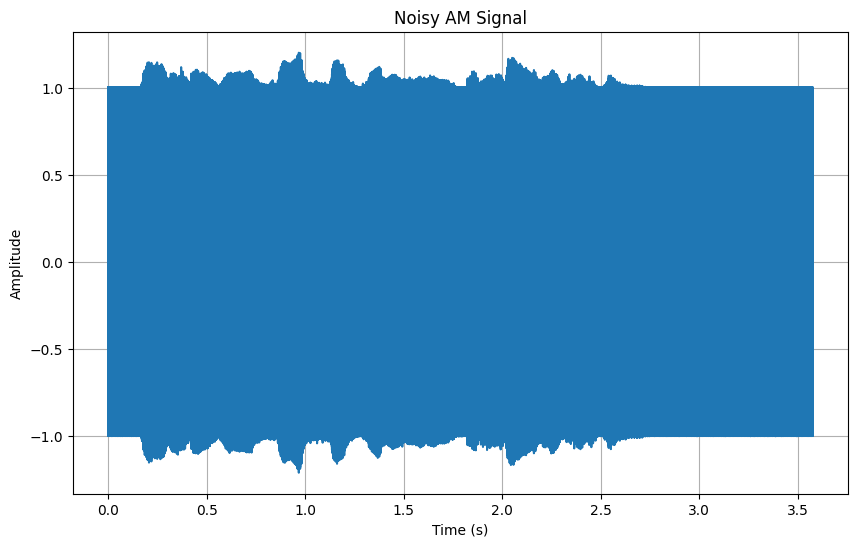

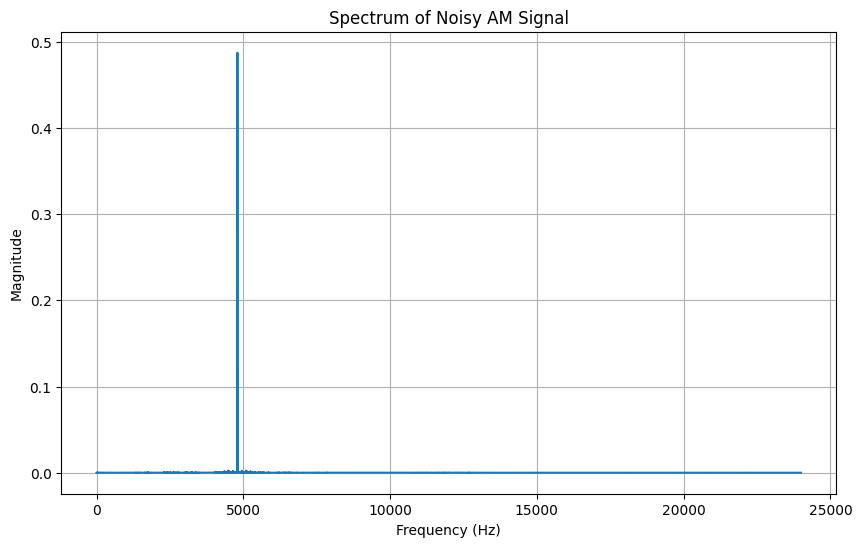

In [9]:
# produce AWGN noise
def awgn(x, snr): # SNR in dB
    snr = 10**(snr/10.0)
    xpower = np.sum(x**2)/len(x)    # power of input signal
    npower = xpower / snr        # power of noise calculated by SNR
    # gaussian noise
    noise = np.random.randn(len(x)) * np.sqrt(npower)
    return noise

# generate AWGN noise
noise_power = 0.001
noise = awgn(am_signal, 60)

# add noise to the AM signal
noisy_am_signal = am_signal + noise

# calculate the pre-detection SNR
pre_snr = 10 * np.log10(np.sum(am_signal**2) / np.sum(noise**2))
print('Pre-detection SNR: {:.2f} dB'.format(pre_snr))

# calculate the theoretical pre-detection SNR
power_orig_data = np.sum(orig_data**2) / len(orig_data)
pre_snr_theo = 10 * np.log10(Ac**2 * (1 + ka * power_orig_data) / (noise_power/fc*bw)) # see textbook eq. 9.26
print('Theoretical pre-detection SNR: {:.2f} dB'.format(pre_snr_theo))

# print the noisy AM signal
plt.figure()
plt.plot(t, noisy_am_signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Noisy AM Signal')
plt.grid(True)
plt.show()

# print the spectrum
plt.figure()
plt.magnitude_spectrum(noisy_am_signal, Fs=fs)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Spectrum of Noisy AM Signal')
plt.grid(True)
plt.show()

# write the noisy AM signal to a wav file, avoid float endoing
wavfile.write('noisy_am_audio.wav', fs, noisy_am_signal.astype(np.int16))

## Step 4: Demodulation

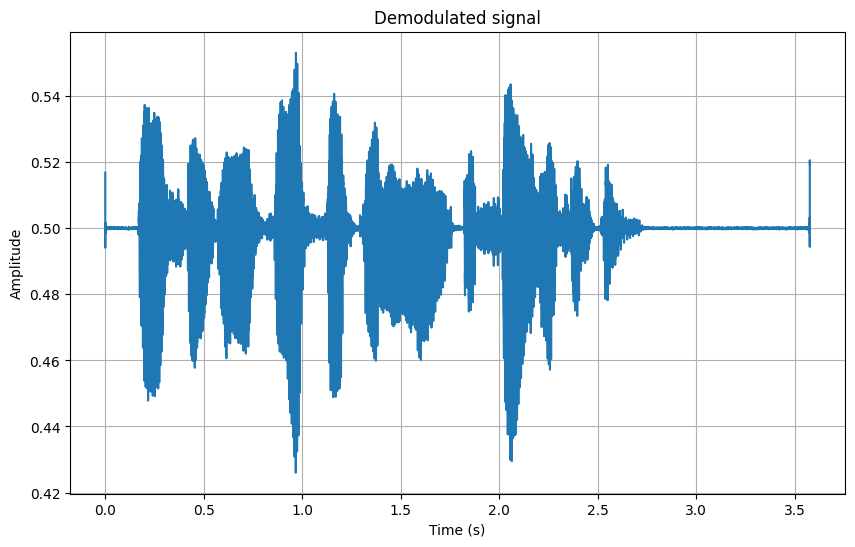

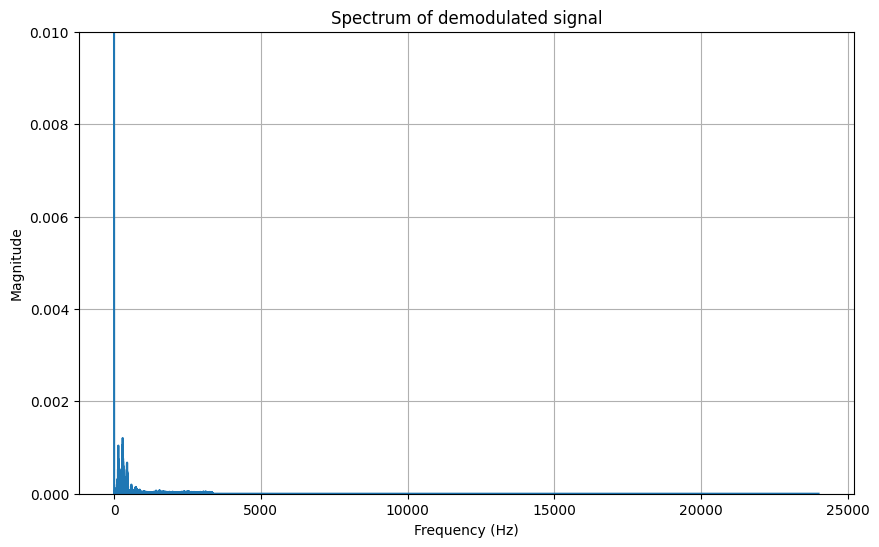

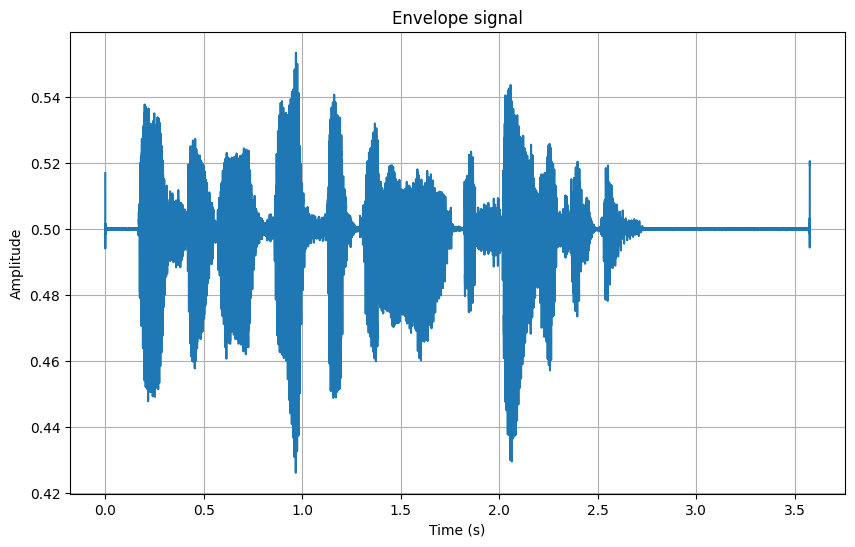

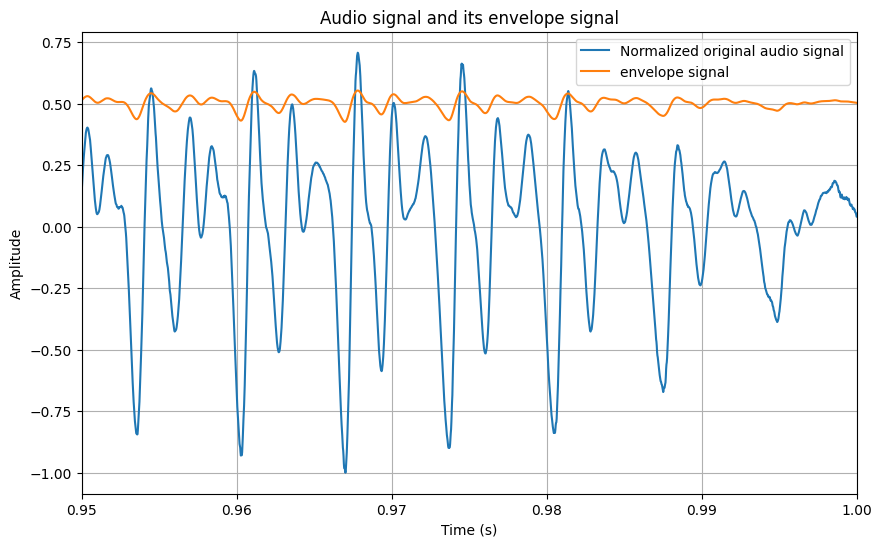

In [10]:
# demodulate the noisy AM signal
# multiply a local oscillator with the am signal
local_oscillator = np.cos(2*np.pi*fc*t)
demodulated_signal = noisy_am_signal * local_oscillator

# calculate the frequency spectrum of the am signal using fft
am_spectrum = np.fft.fft(demodulated_signal)

# lpf
am_spectrum[int(bw/2):] = 0

# calculate the real time-domain signal using ifft
demodulated_signal = np.fft.ifft(am_spectrum)
# take the magnitude
demodulated_signal = np.abs(demodulated_signal)

# plot the demodulated signal
plt.figure()
plt.plot(t, demodulated_signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Demodulated signal')
plt.grid(True)
plt.show()

# plot its spectrum
plt.figure()
plt.magnitude_spectrum(demodulated_signal, Fs=fs)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.ylim(0, 0.01)
plt.title('Spectrum of demodulated signal')
plt.grid(True)
plt.show()

# apply the envelope detector
demodulated_envelope = get_envelope(demodulated_signal)

# plot the envelope signal
plt.figure()
plt.plot(t, demodulated_envelope)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Envelope signal')
plt.grid(True)
plt.show()

# plot the original audio signal and the envelope signal
plt.figure()
plt.plot(t, data, label='Normalized original audio signal')
plt.plot(t, demodulated_envelope, label='envelope signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0.95,1)
plt.title('Audio signal and its envelope signal')
plt.grid(True)
plt.legend()
plt.show()

# write the demodulated signal to a wav file, do not use float
wavfile.write('audio_demodulated.wav', fs, demodulated_signal.astype('int16'))

# write the envelope signal to a wav file, do not use float
wavfile.write('audio_demodulated_envelope.wav', fs, demodulated_envelope.astype('int16'))


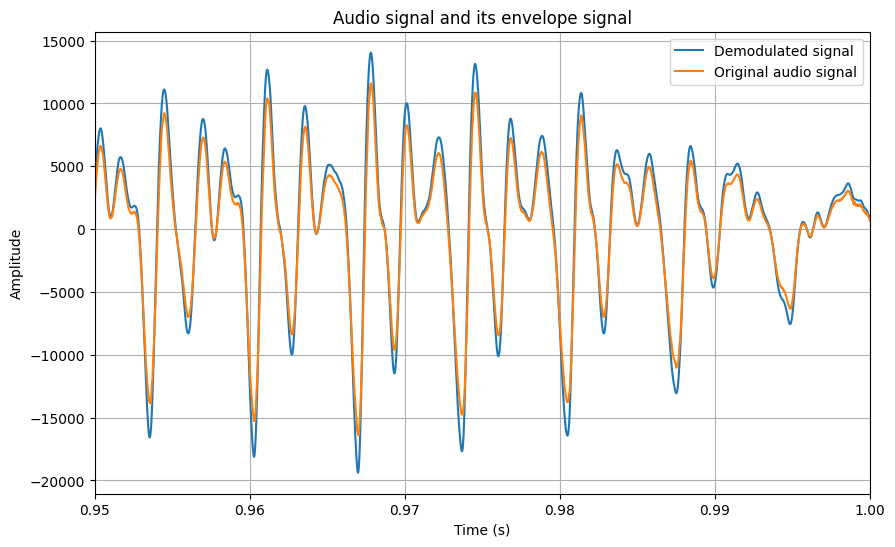

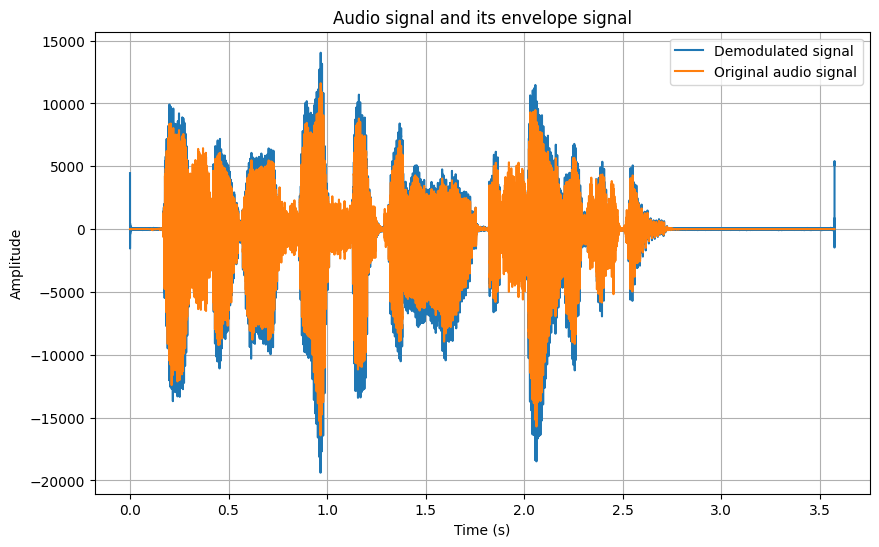

Post-detection SNR: -29.83 dB
Theoretical post-detection SNR: 36.67 dB


In [26]:
# cancel the dc offset
final_demodulated_envelope = (demodulated_envelope - 0.5*Ac) * 2 * nf * 4 * 2

# plot the original audio signal and the envelope signal
plt.figure()
plt.plot(t, final_demodulated_envelope, label='Demodulated signal')
plt.plot(t, orig_data, label='Original audio signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0.95,1)
plt.title('Audio signal and its envelope signal')
plt.grid(True)
plt.legend()
plt.show()

# plot the original audio signal and the envelope signal
plt.figure()
plt.plot(t, final_demodulated_envelope, label='Demodulated signal')
plt.plot(t, orig_data, label='Original audio signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio signal and its envelope signal')
plt.grid(True)
plt.legend()
plt.show()

# calculate the post-detection SNR
post_snr = 10 * np.log10(np.sum(orig_data**2) / np.sum((final_demodulated_envelope - orig_data)**2))

# calculate the theoretical post-detection SNR
post_snr_theo = 10 * np.log10(Ac**2 * ka**2 * power_orig_data / (2*noise_power/fc*bw)) # see textbook eq. 9.26

print('Post-detection SNR: {:.2f} dB'.format(post_snr))
print('Theoretical post-detection SNR: {:.2f} dB'.format(post_snr_theo))

# write the demodulated signal to a wav file, do not use float
wavfile.write('audio_demodulated_final.wav', fs, final_demodulated_envelope.astype('int16'))